In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Example 1


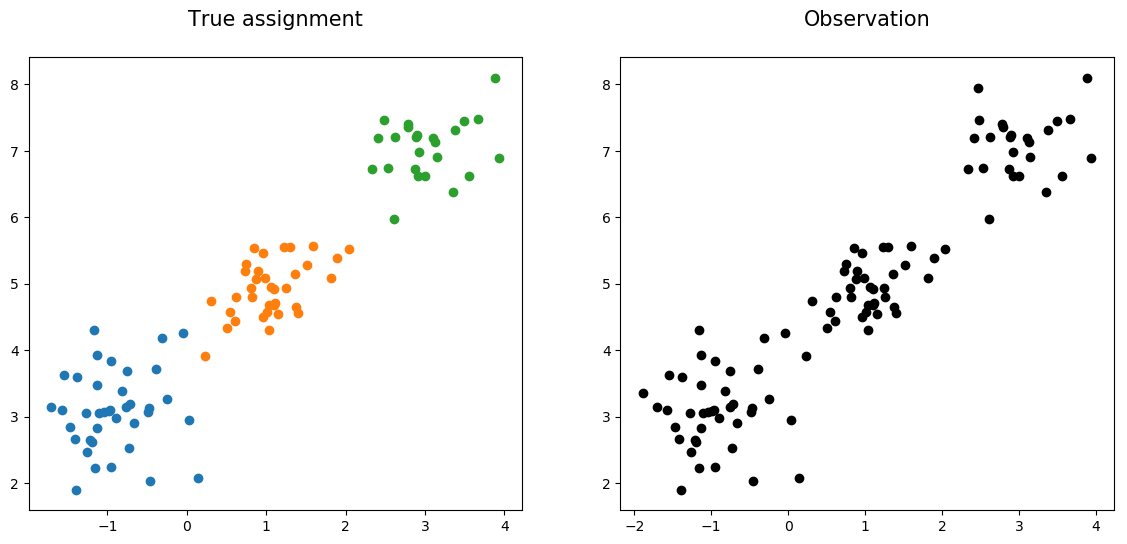

In [3]:
# pi_true; pi_true의 instance는 각각의 random variable이 생성될 확률을 의미함
# mu_true, sigma_true: Multivariate normal distribution의 mean matrix, covariance matrix

pi_true = np.array([0.35, 0.45, 0.2])
mu_true = np.array([[-1, 3], [1, 5], [3,7]])
sigma_true = np.zeros((3, 2, 2))
sigma_true[0] = np.array([[0.9, 0.1], [0.1, 0.9]])/3
sigma_true[1] = np.array([[0.6, 0.4], [0.4, 0.6]])/3
sigma_true[2] = np.array([[0.7, 0.3], [0.3, 0.7]])/3
col = ['red', 'green', 'blue', 'black', 'cyan']

# N: 생성할 random variable의 총 개수
# v[i, j, k]: j번째로 생성된 i번째 random variable(R_i)의 X(k=0) 혹은 Y(k=1)값
# C[i]: 생성된 i번째 random variable(R_i)의 개수

N = 100
v = np.zeros((len(pi_true), N, 2))
C = np.zeros(len(pi_true), dtype = 'int64')
obs = np.zeros((N, 2))

for i in range(N):
    z = np.random.random()
    idx = 0
    needle = 0
    
    for j in range(len(pi_true)): # 랜덤하게 생성된 z가 어떤 random variable(R_i)로 생성될지 결정하는 statement
        if z >= needle and z <= needle + pi_true[j]:
            idx = j
            break
        else:
            needle += pi_true[j]
            
    obs[i] = np.random.multivariate_normal(mu_true[idx], sigma_true[idx]) # 위의 for-statement에서 결정된 idx 값에 따라 random variable을 생성함
    C[idx] += 1 # R_i가 몇개 생성되었는지 기록
    v[idx, C[idx]] = obs[i] # multivariate normal distribution을 따르는 값을 random variable의 i값 및 빈도별로 저장함

plt.figure(1, figsize=(14, 6), dpi=100)
plt.subplot(121)
plt.title('True assignment\n', fontsize=15)
for i in range(len(pi_true)):
    plt.plot(v[i, 1:C[i], 0], v[i, 1:C[i], 1], 'o')
    
plt.subplot(122)
plt.title('Observation\n', fontsize=15)
plt.plot(obs[:, 0], obs[:, 1], 'ko')

plt.show()

## K-means



- $ J=\sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk}||x_n-\mu_k||^2 $ 를 Minimize
    - by Optimizing $r_{nk}$ and $\mu_k$
        - $x_n$: n번째 데이터 포인트 위치  
        - $\mu_k$: k번째 중심의 위치를 나타내는 결정 변수  
        - $r_{nk}$: n번째 데이터 포인트가 k번째 군집에 속하면 1, 그렇지 않으면 0인 이진 결정 변수  



### Expectation and Maximization of K-means:

-  Expectation: $ r_{nk} $를 optimize
    -  Assgining the data points to the nearest Centroid. 
- Maximization of the parameters with respect to the likelihood:
    - $ {{dJ}\over{d\mu_{k}}} =  {{d}\over{d\mu_{k}}}    \sum_{n=1}^{N}\sum_{k=1}^{K} r_{nk} \lVert x_{n} - \mu_{k} \rVert^{2}  $
    - $ \to  \mu_k=\frac{\sum_{n=1}^{N} x_n r_{nk}}{\sum_{n=1}^{N} r_{nk}} $


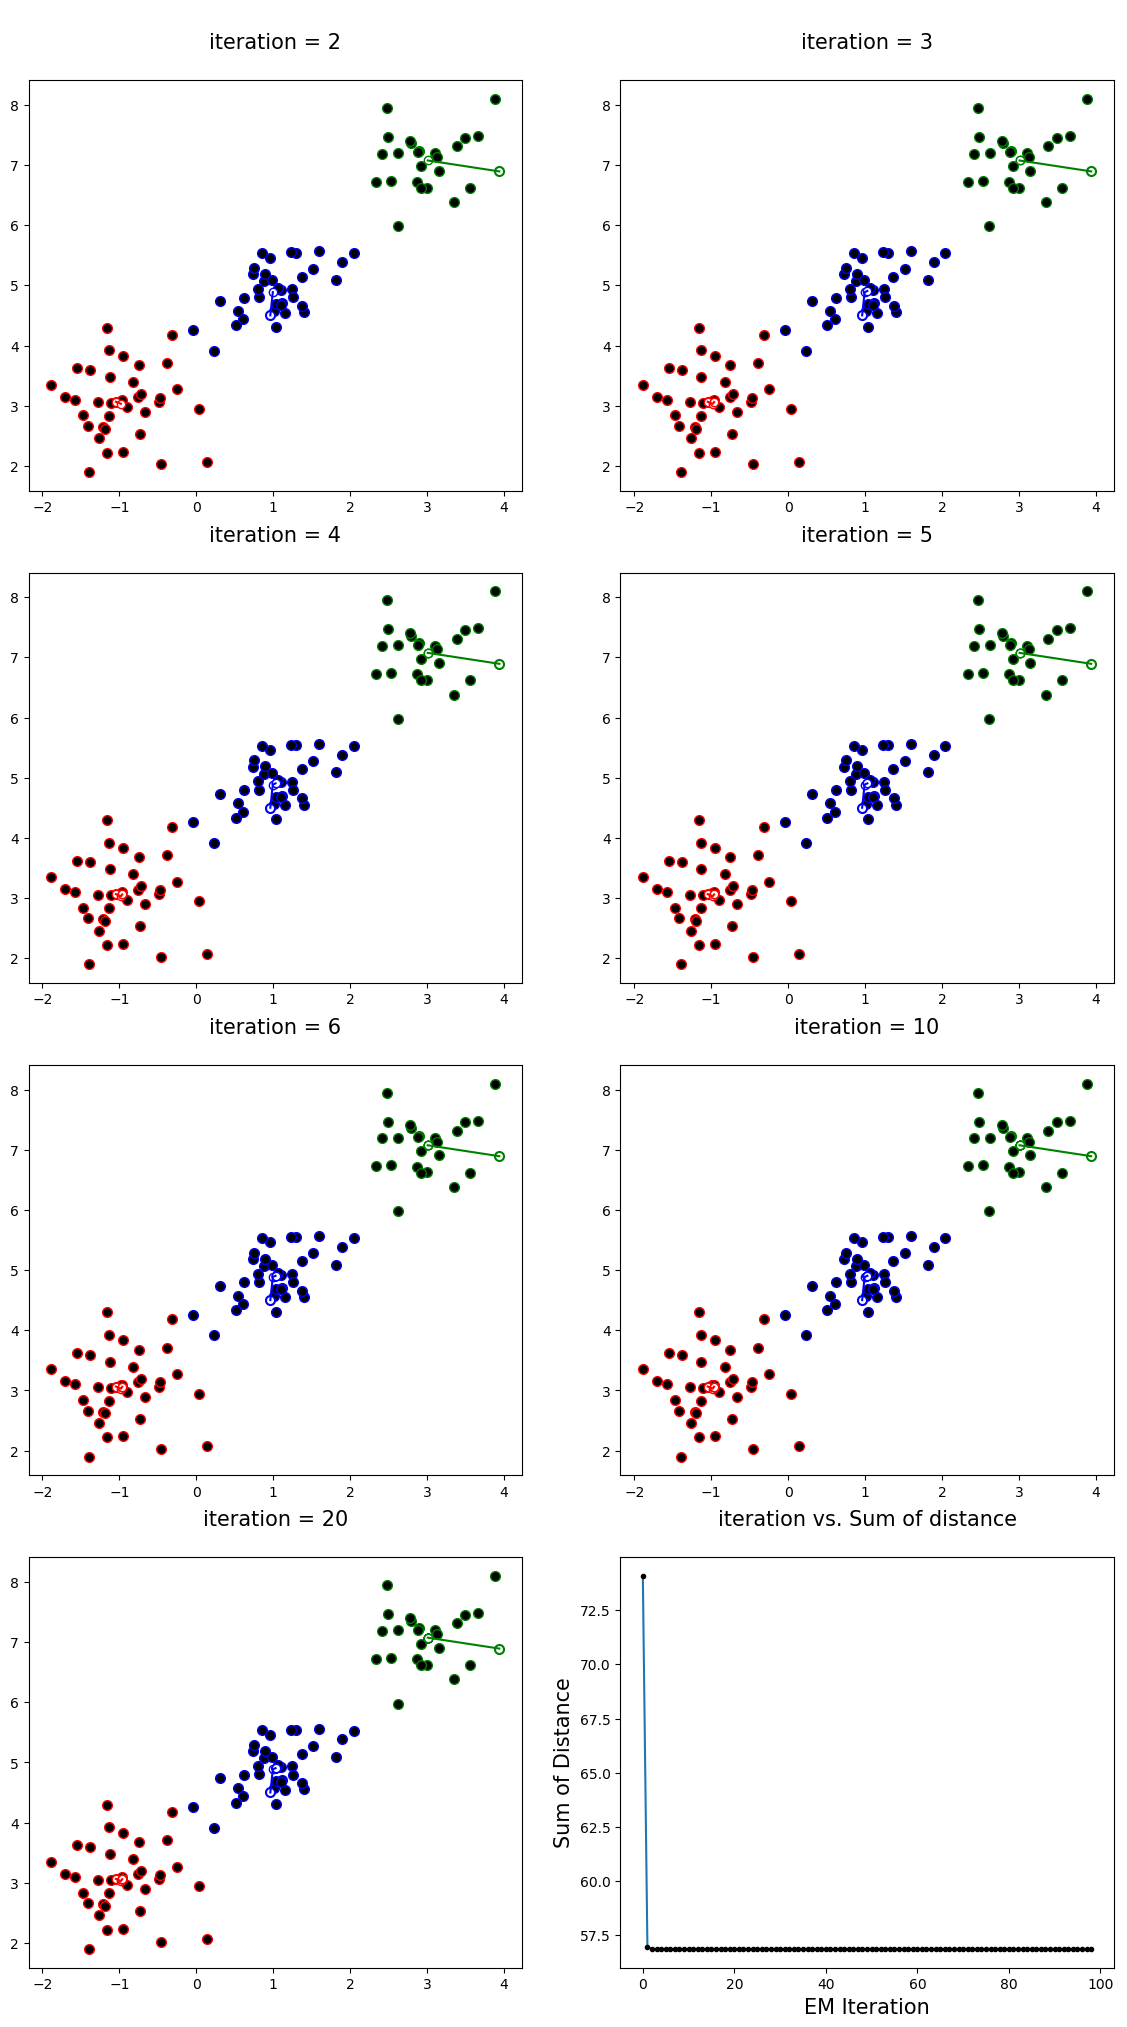

In [4]:
def distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

k = 3 # 군집의 개수
itrEM = 100 # iteration 횟수
showVisualization = [2, 3, 4, 5, 6, 10, 20] # 군집화된 결과를 가시화 할 iteration 횟수

centroid = np.zeros((itrEM, k, 2)) # iterEM(iteration)에 따른 k-th cluster의 무게중심 (X, Y)
sumDistance = np.zeros(itrEM-1) # 목표함수: 데이터 포인트와 군집의 무게 중심의 거리를 모두 더한 값
assignment = np.zeros(N, dtype = 'int64') # N번째 데이터 포인트가 속하는 군집 값

for i in range(k):
    centroid[0, i, :] = obs[i, :] # K개의 데이터 포인트를 무게중심 초기값으로 설정
    
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):       
    for j in range(N): # 생성한 모든 random variable에 대하여 군집화를 실시
        idxK = 0
        minDist = distance(centroid[i-1, 0, :], obs[j, :]) # 첫번째 군집의 무게중심에 대한 데이터 포인트의 거리를 minDist의 초기값으로 설정
        
        #각 데이터 포인트를 가장 가까운 군집에 할당하는 과정 - EM알고리즘에서 E과정
        for l in range(1, k):
            dist = distance(centroid[i-1, l, :], obs[j, :]) # 각각의 무게중심에 대한 데이터 포인트의 거리 계산
            
            if minDist > dist: # 첫번째 군집보다 가까운 군집이 존재할 때, 데이터 포인트가 속하는 군집을 변경해 줌
                minDist = dist
                idxK = l
        assignment[j] = idxK
        sumDistance[i-1] += distance(centroid[i-1, idxK, :], obs[j, :]) # 목표함수 계산
    
    cntGroups = np.zeros(k) + 1e-5 # 해당 군집에 속하는 데이터 포인트가 0인 경우를 위해 1e-5를 더해줌
    
    for j in range(N):        
        cntGroups[assignment[j]] += 1 # 각 군집에 속하는 데이터 포인트 계산
        centroid[i, assignment[j]] += obs[j] # 각 군집에 속하는 데이터 포인트의 좌표값을 더해줌
    
    for j in range(k):
        centroid[i, j] /= cntGroups[j] # 각 군집의 무게중심 값 계산 - EM알고리즘에서 M과정
    
    if i in showVisualization: # 가시화 할 iterEM일 경우 아래의 과정을 수행함
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize = 15)
        plotN += 1
        
        for j in range(k):
                  
            points = np.zeros((int(cntGroups[j]), 2))
            cntTemp = 0
            
            # 해당 데이터포인트가 j 군집에 속할 경우 points에 좌표를 저장함
            for l in range(N):
                if assignment[l] == j: 
                    points[cntTemp] = obs[l]
                    cntTemp += 1
            
            # j 군집에 속하는 point를 검정색 점으로 나타내고, 테두리는 col[j]로 나타냄
            plt.plot(points[:, 0], points[:, 1], 'ko', markeredgecolor = col[j], markersize = 7, markeredgewidth = 1) #검정
            # 초기 군집의 무게중심과 itrEM 후의 무게중심을 흰 점으로 나타내고 테두리는 col[j]로 나타냄
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], 'wo', markeredgecolor = col[j])
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], color = col[j])

# iteration에 따른 목표함수 값의 변화를 나타냄
plt.subplot(4, 2, 8)
plt.title('iteration vs. Sum of distance\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Sum of Distance', fontsize = 15)
plt.plot(sumDistance[:])
plt.plot(sumDistance[:], 'ko', markersize = 3)

plt.show()

## GMM

- [GMM 자세한 설명](https://github.com/NamSahng/Summary/blob/master/Intro2AI%26ML/W8%20K-Means%20%26%20GMM.ipynb)

- 관측된 given 데이터에서 zk(latent)에 대한  assign
    - $ \gamma(z_{nk}) \equiv p(z_{k}=1|x_{n})$ 
    - $ = {{ \pi_{k} N(x|\mu_{k},\boldsymbol{\Sigma_{k}})}\over{\sum_{j=1}^{K} \pi_{j} N(x|\mu_{j},\boldsymbol{\Sigma_{j}})}} \color{red} {\space \cdots \space eq\space(1)} $

- Log-likelihood of given Dataset
    -  $ lnP(X = x|\pi, \mu, \boldsymbol{\Sigma}) = \sum_{n=1}^{N} ln \left\{ \sum_{k=1}^{K} \pi_{k} N(x|\mu_{k},\boldsymbol{\Sigma_{k}})  \right\} \color{red} {\space \cdots \space eq\space(2)} $
    

### Expectation and Maximization of GMM:

- Expectation of GMM
    - given $ x, \pi, \mu, \boldsymbol{\Sigma} $ 에 대해  $ \gamma(z_{nk}) $ 계산 (eq 1)


    
- Maximization of GMM
    - given $ \gamma(z_{nk})  $ 를 활용해, $ \pi, \mu, \boldsymbol{\Sigma} $를 update
    - $ {{d}\over{d \mu}} lnP(X|\pi, \mu, \boldsymbol{\Sigma}) = 0 $
        -  $ \to \hat{\mu_{k}} = {{\sum_{n=1}^{N}\gamma(z_{nk})x_{n}}\over{\sum_{n=1}^{N} \gamma(z_{nk}) }} \color{red}{\space...\space eq\space(3)} $
    - $ {{d}\over{d \boldsymbol{\Sigma}}} lnP(X|\pi, \mu, \boldsymbol{\Sigma}) = 0 $
        - $ \to \hat{\boldsymbol{\Sigma_{k}}} =  {{\sum_{n=1}^{N}\gamma(z_{nk}) (x-\hat{\mu_{k}})(x_{n}-\hat{\mu_{k}})^{T}}\over{\sum_{n=1}^{N} \gamma(z_{nk}) }} \color{red}{\space...\space eq\space(4)} $
    - $ {{d}\over{d \pi }} lnP(X|\pi, \mu, \boldsymbol{\Sigma}) + \lambda (\sum_{k=1}^{K} \pi_{k}-1) = 0$
        - $ \to \lambda = -N $
        - $ \to \hat{\pi_{k}} = {{\sum_{n=1}^{N}\gamma(z_{nk})}\over{N}} \color{red}{\space...\space eq\space(5)} $





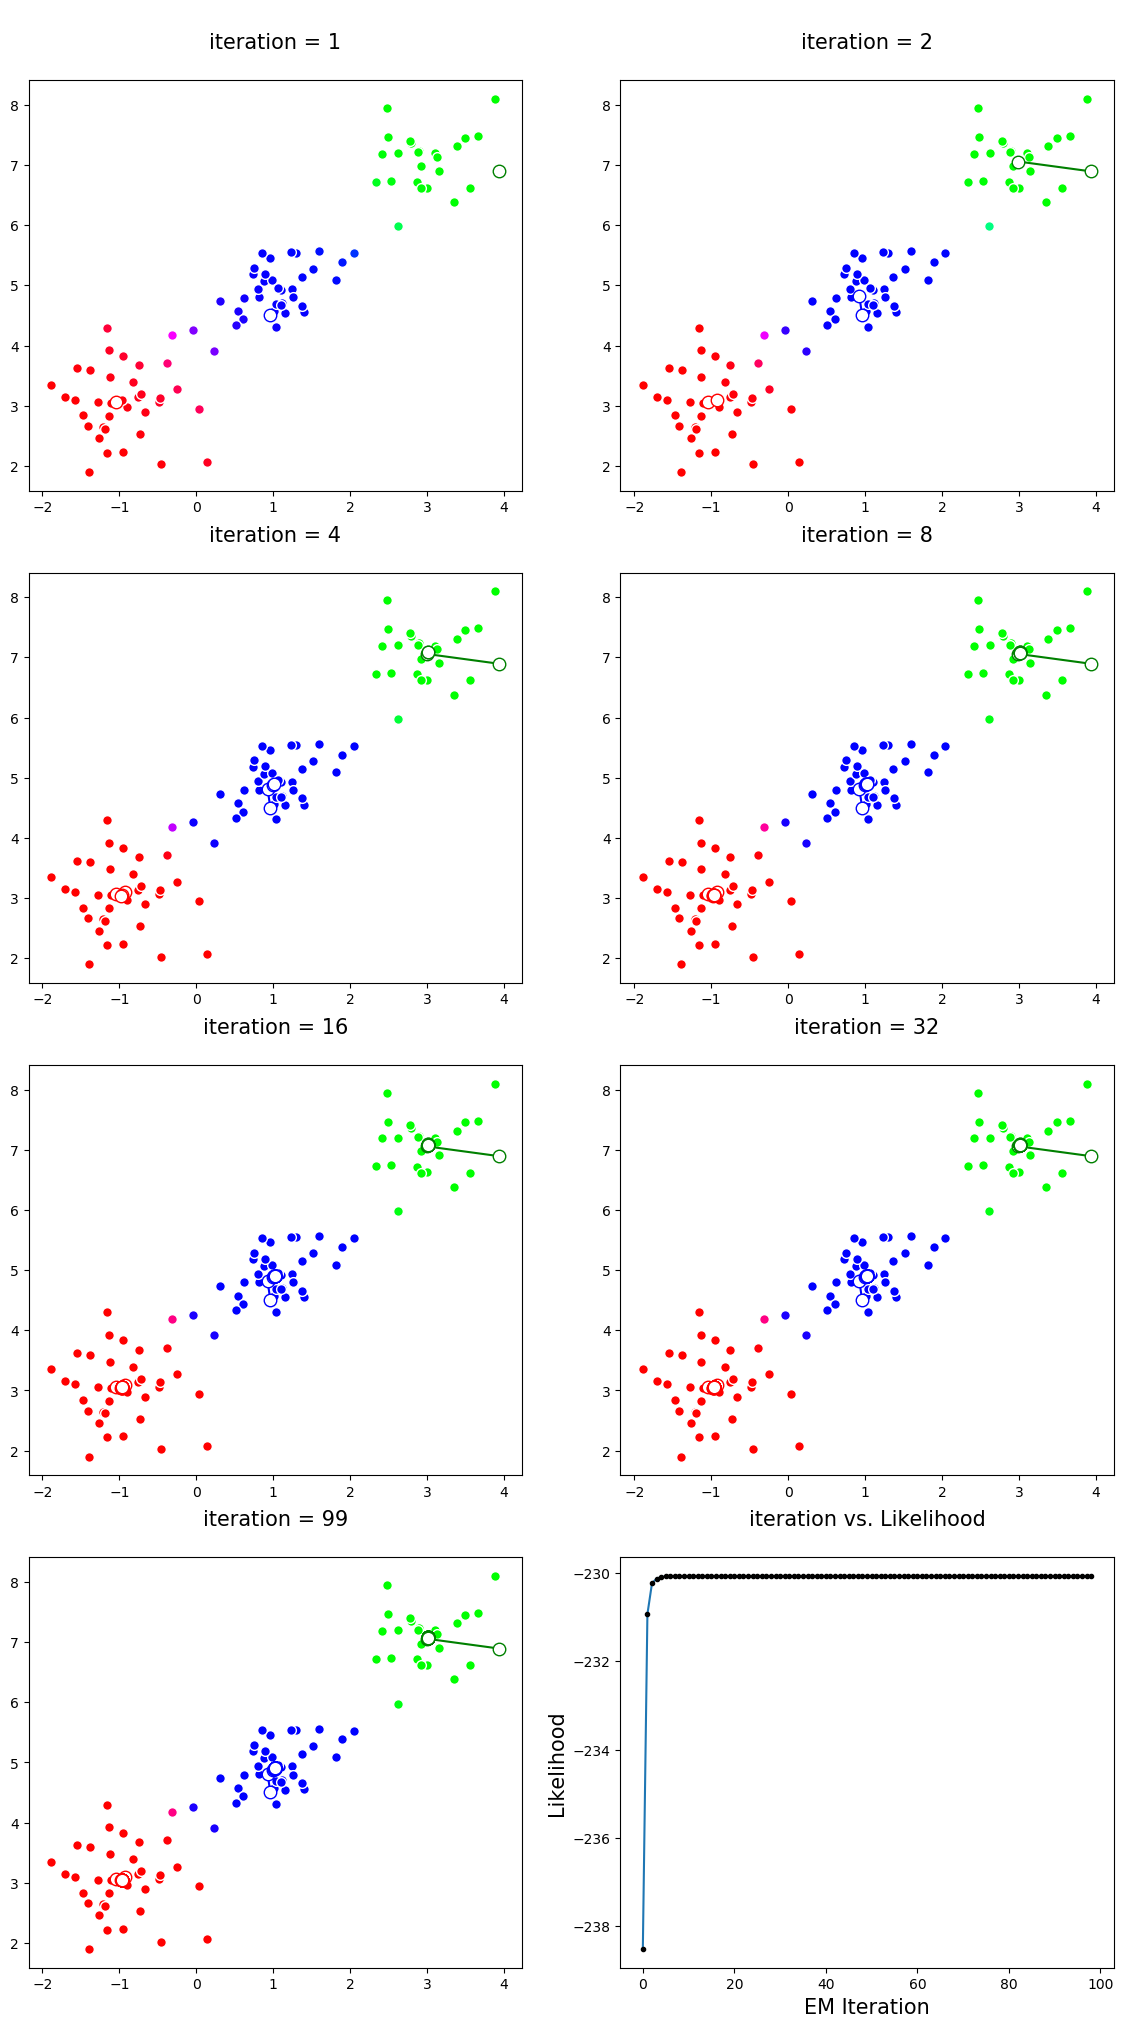

In [5]:
k = 3
itrEM = 100
showVisualization = [1, 2, 4, 8, 16, 32, 99]

mu = np.zeros((itrEM, k, 2))
sigma = np.zeros((itrEM, k, 2, 2))
pi = np.zeros((itrEM, k))
likelihood = np.zeros(itrEM-1) # 로그우도값
assignment = np.zeros((N, k)) # n번째 데이터가 k번째 군집에 속해 있을 확률값

for i in range(k):
    mu[0, i] = obs[i]
    sigma[0, i] = np.eye(2)
    pi[0, i] = 1.0 / k
    
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):
    
    # EM알고리즘 기댓값(E) 과정...eq(1)
    for j in range(N):
        for l in range(k):
            assignment[j, l] = pi[i-1, l] * multivariate_normal.pdf(obs[j, :], mu[i-1, l], sigma[i-1, l])
            
        assignment[j] /= np.sum(assignment[j])
    
    # EM알고리즘의 최대화(M) 과정
    ## mu의 최우추정값을 구하는 과정...eq(3)
    for j in range(k):
        normalize = 0
        mu[i, j] = np.zeros((1,2))
        
        for l in range(N):
            mu[i,j] += assignment[l, j] * obs[l]
            normalize +=  assignment[l, j]
        
        mu[i, j] /= normalize
    
    ## Sigma의 최우추정값을 구하는 과정...eq(4)
    for j in range(k):
        normalize = 0
        sigma[i, j] = np.zeros((2,2))
        
        for l in range(N):
            sigma[i, j] += assignment[l, j] * np.multiply(np.transpose([obs[l] - mu[i, j]]), obs[l] - mu[i, j])
            normalize += assignment[l, j]
            
        sigma[i, j] /= normalize
    
    ## pi의 최우추정값을 구하는 과정...eq(5)
    for j in range(k):
        for l in range(N):
            pi[i, j] += assignment[l, j]
            
        pi[i, j] /= N
        
    ## 로그 우도값(log liklihood)의 계산...eq(2)
    likelihood[i-1] = 0
    for j in range(N):        
        sumL = 0
        
        for l in range(k):
            sumL += pi[i, l] * multivariate_normal.pdf(obs[j], mu[i, l], sigma[i, l])
        
        likelihood[i-1] += np.log(sumL)
        
    if i in showVisualization:
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize=15)
        plotN += 1
        
        for j in range(N):
            assignment[j] /= np.max(assignment[j])
            # 각 군집에 속할 확률로 weighted된 색으로 데이터 포인트를 나타냄
            plt.plot(obs[j, 0], obs[j, 1], 'o', markersize = 7, 
                     markerfacecolor = (assignment[j, 0], assignment[j, 1], assignment[j, 2]), markeredgecolor = 'w')
        
        for j in range(k):
            points = np.zeros((i, 2))
            
            for l in range(i):
                points[l] = mu[l, j]
            # iteration마다 이동하는 다변수 가우스 분포의 평균값 벡터를 나타냄
            plt.plot(points[:, 0], points[:, 1], color = col[j])
            plt.plot(points[:, 0], points[:, 1], 'wo', markeredgecolor = col[j], markersize = 9, markeredgewidth = 1)

# iteration에 따른 로그우도값을 나타냄          
plt.subplot(4, 2, 8)
plt.title('iteration vs. Likelihood\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Likelihood', fontsize = 15)
plt.plot(likelihood[:])
plt.plot(likelihood[:], 'ko', markersize = 3)


plt.show()
    


## Example 2

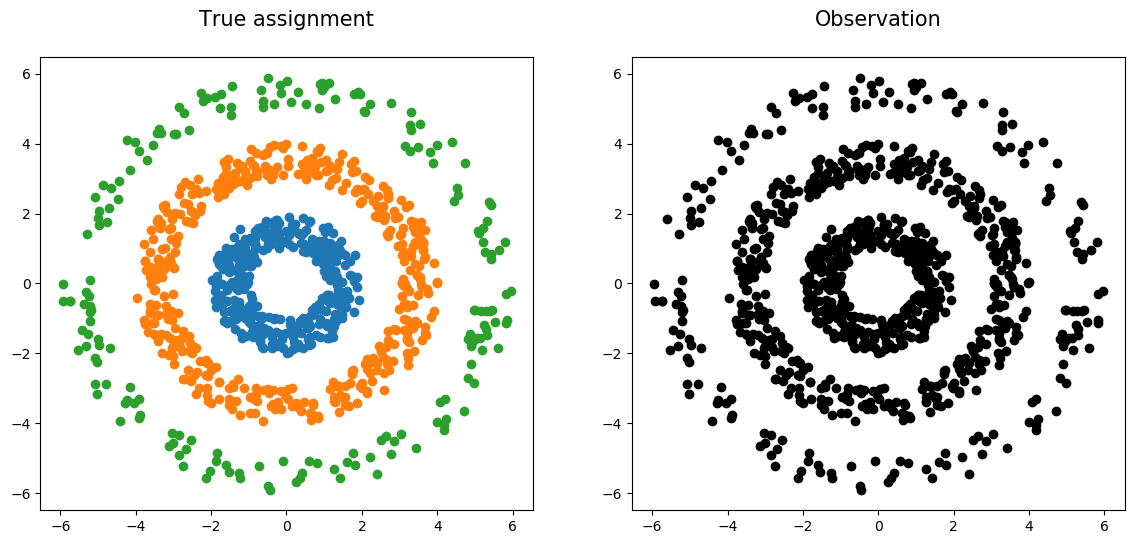

In [6]:
pi_true = np.array([0.35, 0.45, 0.2])
mu_true = np.array([[0, 0], [0, 0], [0, 0]])
sigma_true = np.zeros((3, 2, 2))
radius = np.array([1, 3, 5])
col = ['r', 'g', 'b', 'k', 'c']

N = 1000
v = np.zeros((len(pi_true), N, 2))
C = np.zeros(len(pi_true), dtype = 'int64')
obs = np.zeros((N, 2))

for i in range(N):
    z = np.random.random()
    idx = 0
    needle = 0
    
    for j in range(len(pi_true)):
        if z >= needle and z <= needle + pi_true[j]:
            idx = j
            break
        else:
            needle += pi_true[j]
    
    # angle ~ Unif[0, 2*pi]
    angle = 2 * np.pi * np.random.random()
    # r ~ Unif[radius[idx], radius[idx]+1]
    r = np.random.random() + radius[idx]
    x = r * np.cos(angle)
    y = r * np.sin(angle)
    C[idx] += 1
    obs[i] = [x, y]
    v[idx, C[idx]] = [x, y]

plt.figure(1, figsize=(14, 6), dpi=100)
plt.subplot(121)
plt.title('True assignment\n', fontsize=15)
for i in range(len(pi_true)):
    plt.plot(v[i, 1:C[i], 0], v[i, 1:C[i], 1], 'o')
    
plt.subplot(122)
plt.title('Observation\n', fontsize=15)
plt.plot(obs[:, 0], obs[:, 1], 'ko')

plt.show()

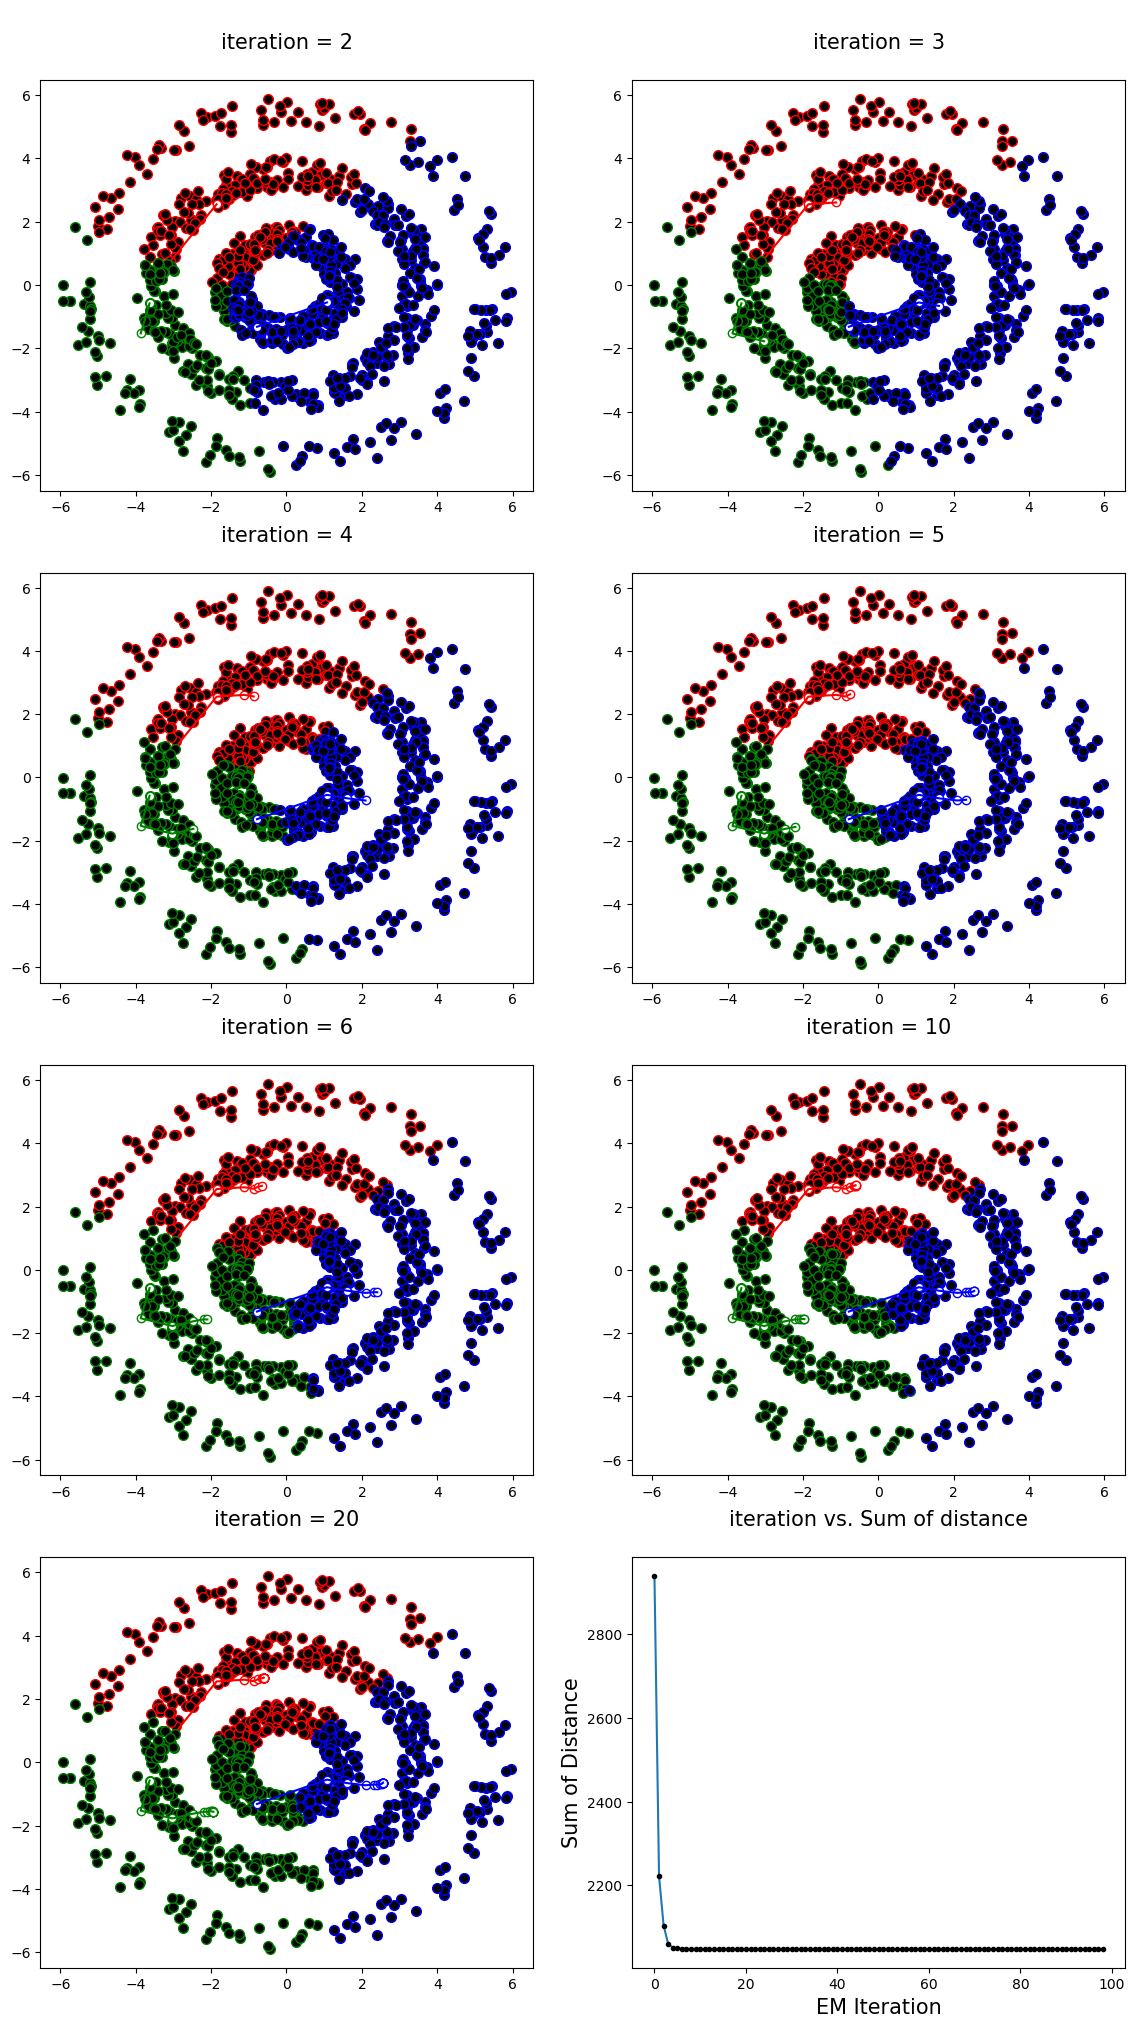

In [7]:
def distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

k = 3 # 군집의 개수
itrEM = 100 # iteration 횟수
showVisualization = [2, 3, 4, 5, 6, 10, 20] # 군집화된 결과를 가시화 할 iteration 횟수

centroid = np.zeros((itrEM, k, 2)) # iterEM(iteration)에 따른 k-th cluster의 무게중심 (X, Y)
sumDistance = np.zeros(itrEM-1) # 목표함수: 데이터 포인트와 군집의 무게 중심의 거리를 모두 더한 값
assignment = np.zeros(N, dtype = 'int64') # N번째 데이터 포인트가 속하는 군집 값

for i in range(k):
    centroid[0, i, :] = obs[i, :] # K개의 데이터 포인트를 무게중심 초기값으로 설정
    
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):       
    for j in range(N): # 생성한 모든 random variable에 대하여 군집화를 실시
        idxK = 0
        minDist = distance(centroid[i-1, 0, :], obs[j, :]) # 첫번째 군집의 무게중심에 대한 데이터 포인트의 거리를 minDist의 초기값으로 설정
        
        #각 데이터 포인트를 가장 가까운 군집에 할당하는 과정 - EM알고리즘에서 E과정
        for l in range(1, k):
            dist = distance(centroid[i-1, l, :], obs[j, :]) # 각각의 무게중심에 대한 데이터 포인트의 거리 계산
            
            if minDist > dist: # 첫번째 군집보다 가까운 군집이 존재할 때, 데이터 포인트가 속하는 군집을 변경해 줌
                minDist = dist
                idxK = l
        assignment[j] = idxK
        sumDistance[i-1] += distance(centroid[i-1, idxK, :], obs[j, :]) # 목표함수 계산
    
    cntGroups = np.zeros(k) + 1e-5 # 해당 군집에 속하는 데이터 포인트가 0인 경우를 위해 1e-5를 더해줌
    
    for j in range(N):        
        cntGroups[assignment[j]] += 1 # 각 군집에 속하는 데이터 포인트 계산
        centroid[i, assignment[j]] += obs[j] # 각 군집에 속하는 데이터 포인트의 좌표값을 더해줌
    
    for j in range(k):
        centroid[i, j] /= cntGroups[j] # 각 군집의 무게중심 값 계산 - EM알고리즘에서 M과정
    
    if i in showVisualization: # 가시화 할 iterEM일 경우 아래의 과정을 수행함
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize = 15)
        plotN += 1
        
        for j in range(k):
                  
            points = np.zeros((int(cntGroups[j]), 2))
            cntTemp = 0
            
            # 해당 데이터포인트가 j 군집에 속할 경우 points에 좌표를 저장함
            for l in range(N):
                if assignment[l] == j: 
                    points[cntTemp] = obs[l]
                    cntTemp += 1
            
            # j 군집에 속하는 point를 검정색 점으로 나타내고, 테두리는 col[j]로 나타냄
            plt.plot(points[:, 0], points[:, 1], 'ko', markeredgecolor = col[j], markersize = 7, markeredgewidth = 1) #검정
            # 초기 군집의 무게중심과 itrEM 후의 무게중심을 흰 점으로 나타내고 테두리는 col[j]로 나타냄
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], 'wo', markeredgecolor = col[j])
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], color = col[j])

# iteration에 따른 목표함수 값의 변화를 나타냄
plt.subplot(4, 2, 8)
plt.title('iteration vs. Sum of distance\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Sum of Distance', fontsize = 15)
plt.plot(sumDistance[:])
plt.plot(sumDistance[:], 'ko', markersize = 3)

plt.show()

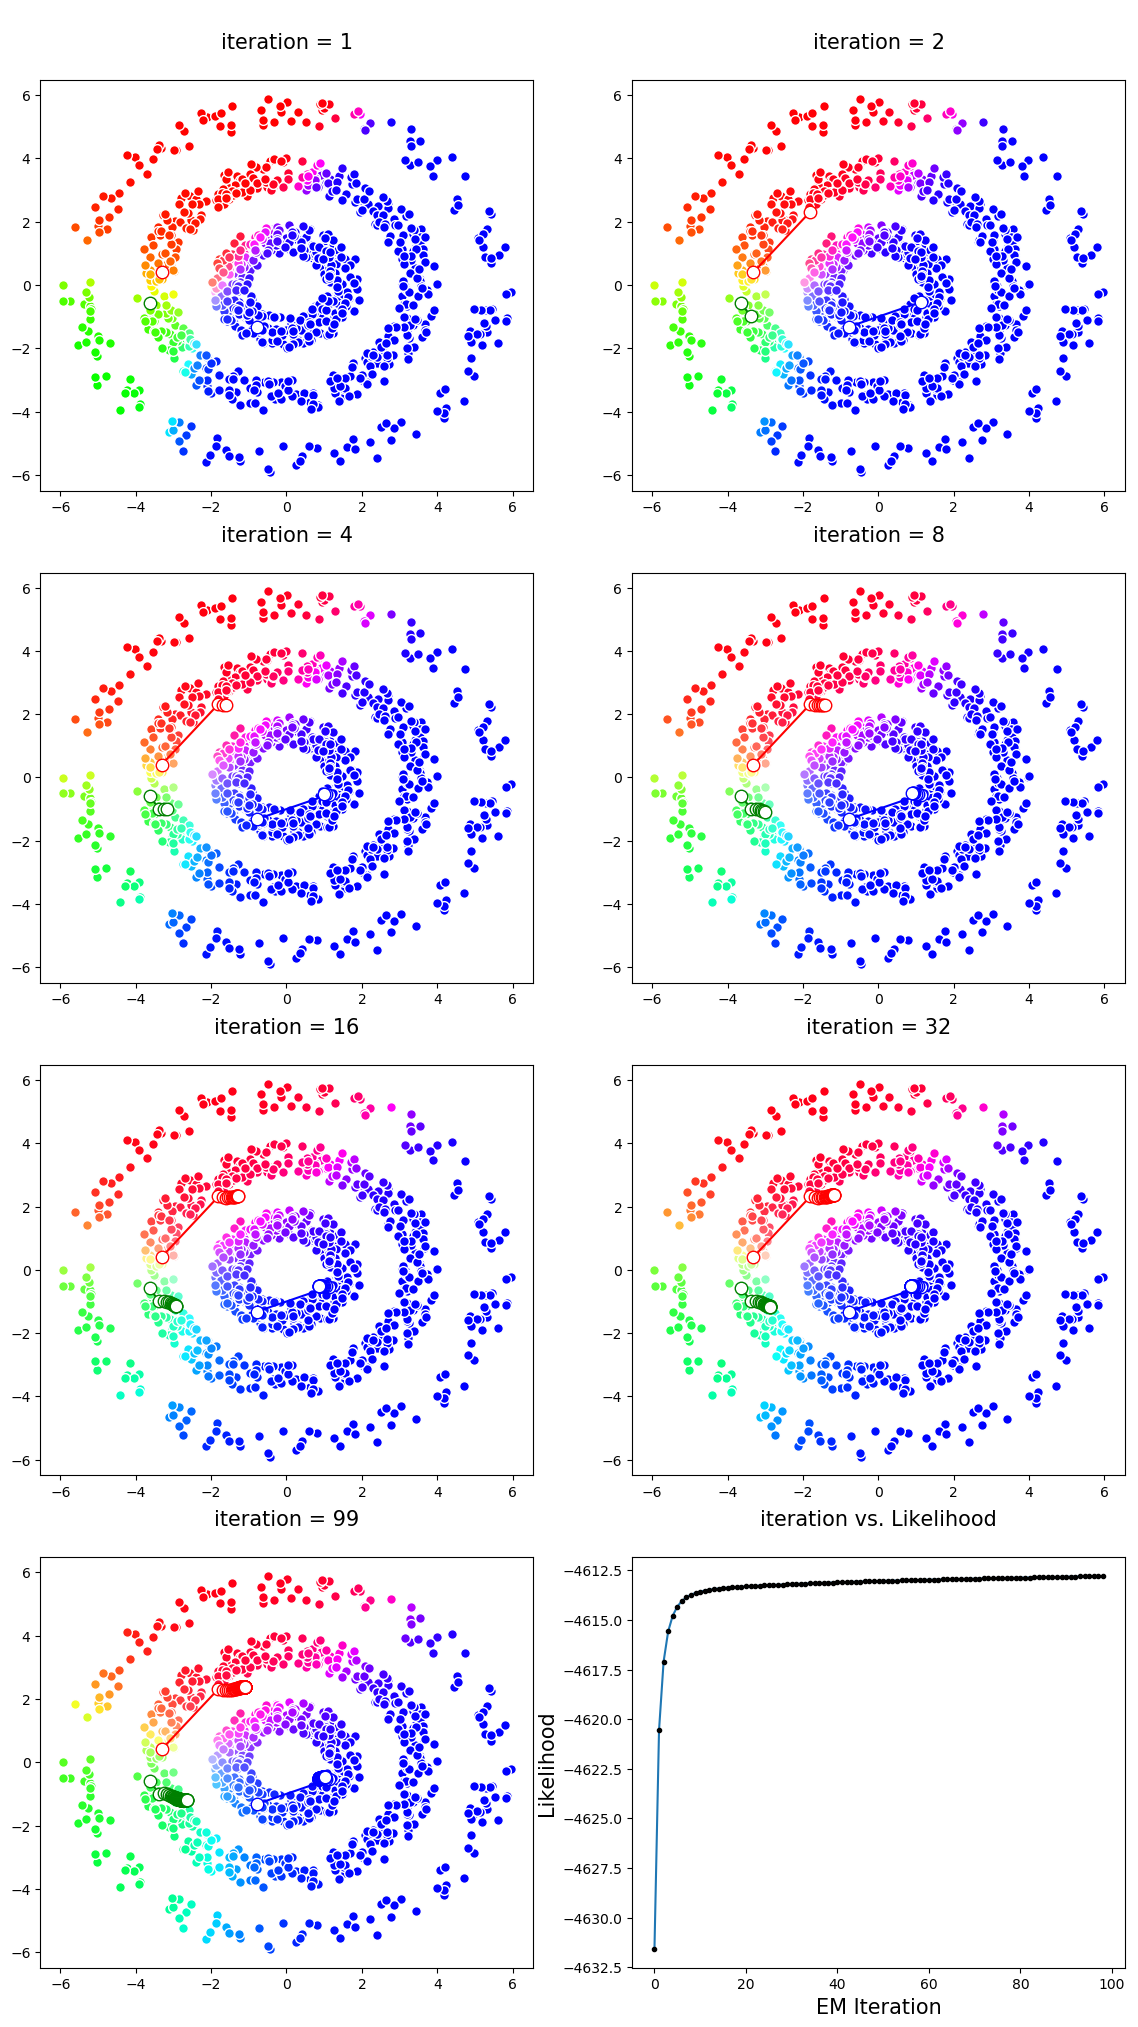

In [8]:
k = 3
itrEM = 100
showVisualization = [1, 2, 4, 8, 16, 32, 99]

mu = np.zeros((itrEM, k, 2))
sigma = np.zeros((itrEM, k, 2, 2))
pi = np.zeros((itrEM, k))
likelihood = np.zeros(itrEM-1) # 로그우도값
assignment = np.zeros((N, k)) # n번째 데이터가 k번째 군집에 속해 있을 확률값

for i in range(k):
    mu[0, i] = obs[i]
    sigma[0, i] = np.eye(2)
    pi[0, i] = 1.0 / k
    
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):
    
    # EM알고리즘 기댓값(E) 과정...eq(1)
    for j in range(N):
        for l in range(k):
            assignment[j, l] = pi[i-1, l] * multivariate_normal.pdf(obs[j, :], mu[i-1, l], sigma[i-1, l])
            
        assignment[j] /= np.sum(assignment[j])
    
    # EM알고리즘의 최대화(M) 과정
    ## mu의 최우추정값을 구하는 과정...eq(3)
    for j in range(k):
        normalize = 0
        mu[i, j] = np.zeros((1,2))
        
        for l in range(N):
            mu[i,j] += assignment[l, j] * obs[l]
            normalize +=  assignment[l, j]
        
        mu[i, j] /= normalize
    
    ## Sigma의 최우추정값을 구하는 과정...eq(4)
    for j in range(k):
        normalize = 0
        sigma[i, j] = np.zeros((2,2))
        
        for l in range(N):
            sigma[i, j] += assignment[l, j] * np.multiply(np.transpose([obs[l] - mu[i, j]]), obs[l] - mu[i, j])
            normalize += assignment[l, j]
            
        sigma[i, j] /= normalize
    
    ## pi의 최우추정값을 구하는 과정...eq(5)
    for j in range(k):
        for l in range(N):
            pi[i, j] += assignment[l, j]
            
        pi[i, j] /= N
        
    ## 로그 우도값(log liklihood)의 계산...eq(2)
    likelihood[i-1] = 0
    for j in range(N):        
        sumL = 0
        
        for l in range(k):
            sumL += pi[i, l] * multivariate_normal.pdf(obs[j], mu[i, l], sigma[i, l])
        
        likelihood[i-1] += np.log(sumL)
        
    if i in showVisualization:
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize=15)
        plotN += 1
        
        for j in range(N):
            assignment[j] /= np.max(assignment[j])
            # 각 군집에 속할 확률로 weighted된 색으로 데이터 포인트를 나타냄
            plt.plot(obs[j, 0], obs[j, 1], 'o', markersize = 7, 
                     markerfacecolor = (assignment[j, 0], assignment[j, 1], assignment[j, 2]), markeredgecolor = 'w')
        
        for j in range(k):
            points = np.zeros((i, 2))
            
            for l in range(i):
                points[l] = mu[l, j]
            # iteration마다 이동하는 다변수 가우스 분포의 평균값 벡터를 나타냄
            plt.plot(points[:, 0], points[:, 1], color = col[j])
            plt.plot(points[:, 0], points[:, 1], 'wo', markeredgecolor = col[j], markersize = 9, markeredgewidth = 1)

# iteration에 따른 로그우도값을 나타냄          
plt.subplot(4, 2, 8)
plt.title('iteration vs. Likelihood\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Likelihood', fontsize = 15)
plt.plot(likelihood[:])
plt.plot(likelihood[:], 'ko', markersize = 3)


plt.show()
    


## Example 3

- This example shows characteristics of different clustering algorithms on datasets that are “interesting” but still in 2D. With the exception of the last dataset, the parameters of each of these dataset-algorithm pairs has been tuned to produce good clustering results. Some algorithms are more sensitive to parameter values than others.


- The last dataset is an example of a ‘null’ situation for clustering: the data is homogeneous, and there is no good clustering. For this example, the null dataset uses the same parameters as the dataset in the row above it, which represents a mismatch in the parameter values and the data structure.


- ** While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data. **

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\graph.py:115: FutureWarning: Conve

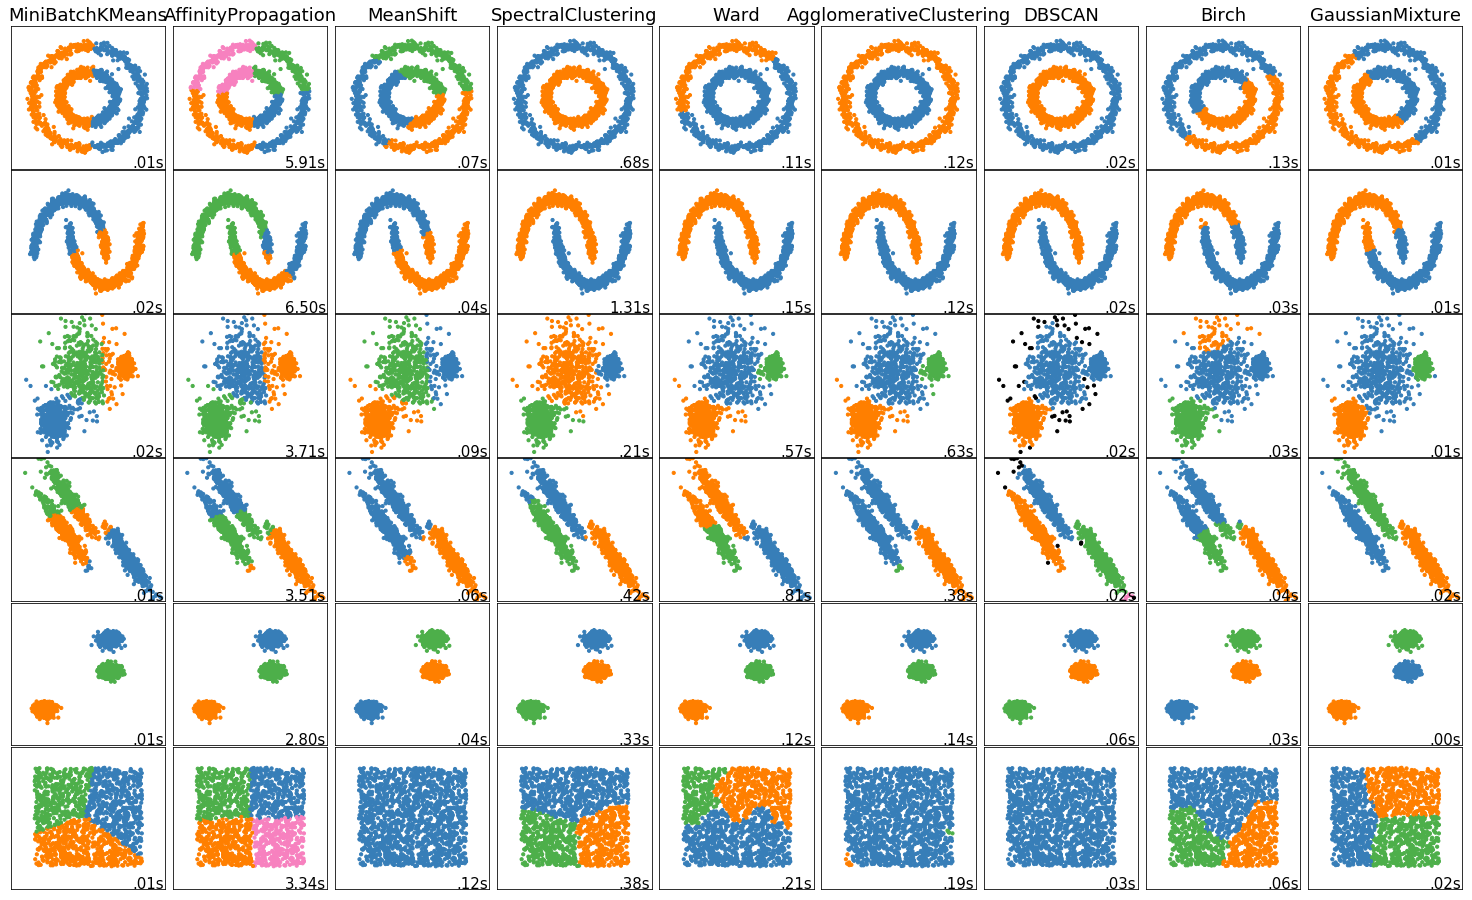

In [9]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## References

- codes & articles:
    - example 1&2: 
        - https://github.com/aailabkaist/Introduction-to-Artificial-Intelligence-Machine-Learning
    - example 3:    
        - https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
    - Articles:
        - https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68
        - https://www.toptal.com/machine-learning/clustering-algorithms
        - https://datascienceschool.net/view-notebook/094bcb7b86574711a2e8d81f26bce2f5/